In [2]:
import numpy as np

import sys
sys.path.append('../..')

from vae import VAEModel
from load_data import load_mnist

## Load data

In [3]:
X_train, y_train, X_test, y_test = load_mnist(binarize=True)

## Train VAE

In [4]:
model = VAEModel(latent_dim=2, beta=.5, alpha_lrelu=0.05)

Epoch 0: error = 225.202
Epoch 10: error = 144.7415
Epoch 20: error = 136.8577
Epoch 30: error = 132.6505
Epoch 40: error = 130.7078
Epoch 50: error = 127.772
Epoch 60: error = 126.8682
Epoch 70: error = 124.9713
Epoch 80: error = 124.7512
Epoch 90: error = 123.4592
Epoch 100: error = 124.5658
Epoch 110: error = 122.169
Epoch 120: error = 122.3286
Epoch 130: error = 123.1322
Epoch 140: error = 121.0521
Epoch 150: error = 121.3112
Epoch 160: error = 120.97
Epoch 170: error = 120.6619
Epoch 180: error = 120.2002
Epoch 190: error = 119.2211
Epoch 200: error = 119.6069
Epoch 210: error = 119.8104
Epoch 220: error = 118.7823
Epoch 230: error = 119.0658
Epoch 240: error = 118.6839
Epoch 250: error = 118.4605
Epoch 260: error = 118.8885
Epoch 270: error = 117.9746
Epoch 280: error = 118.7007
Epoch 290: error = 117.5741
Epoch 300: error = 117.3149
Epoch 310: error = 117.6663
Epoch 320: error = 118.0479
##### PATIENCE TRIGGERED!
Epoch 330: error = 118.582


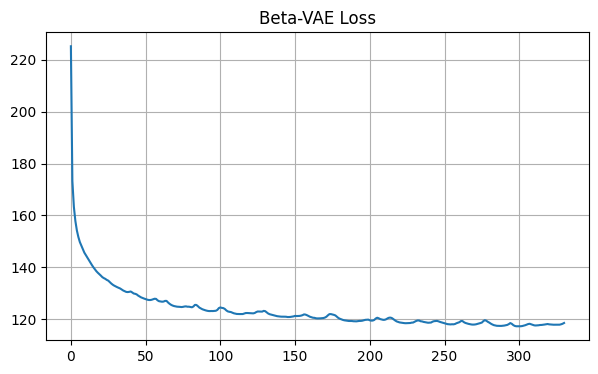

In [5]:
_ = model.train_vae(X_train, 5000, learning_rate=3e-4, batch_size=256, print_error_every=10, patience=30)

Test loss = 31.25


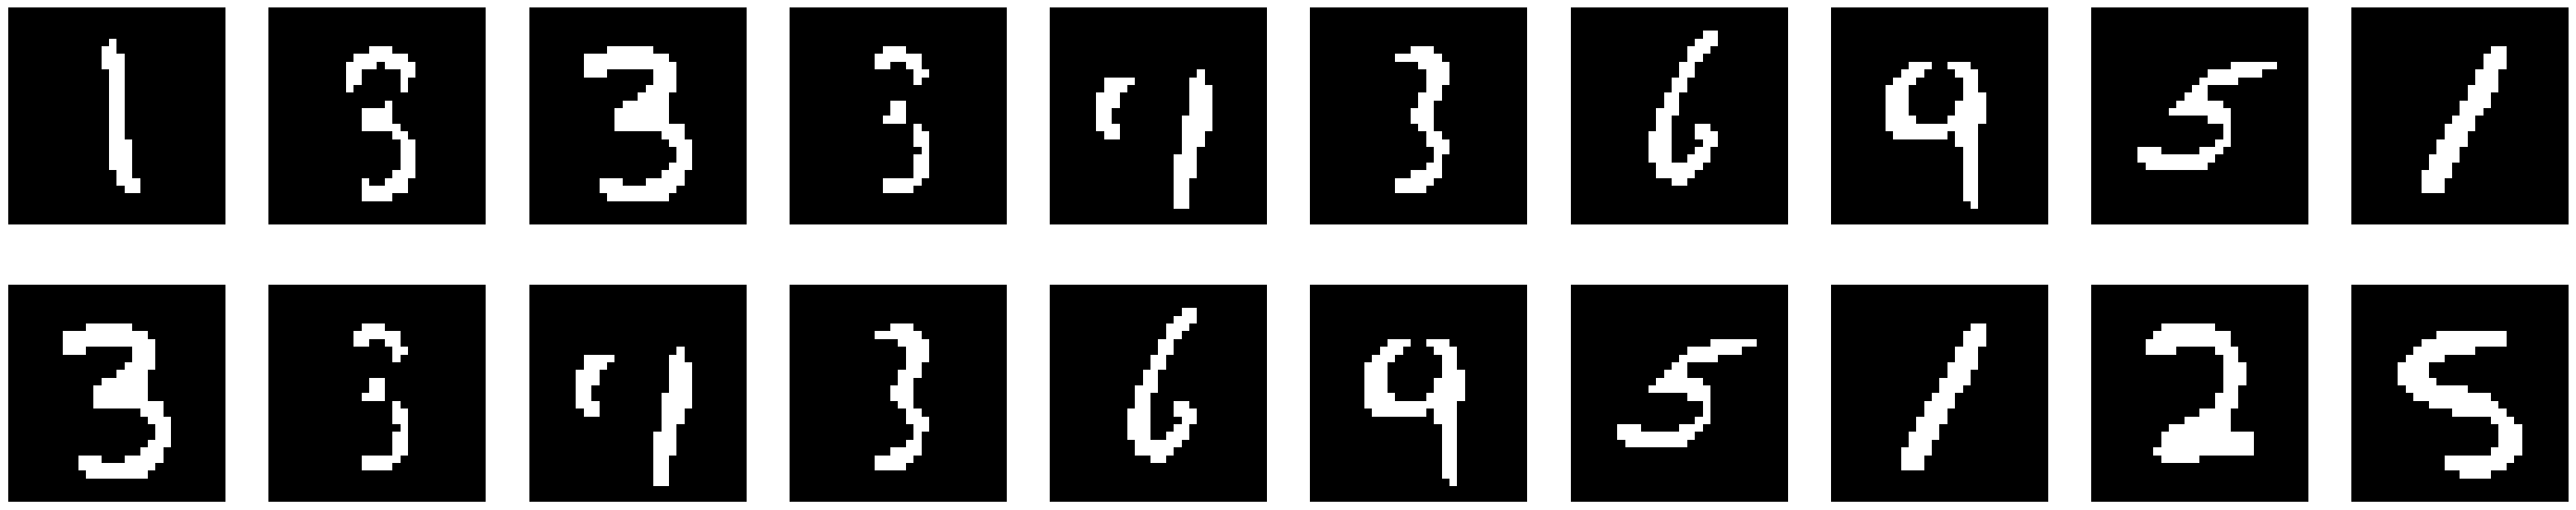

In [6]:
l, r = model.test_vae(X_test, ncols=10, nb_to_plot=20)

## Generate new samples

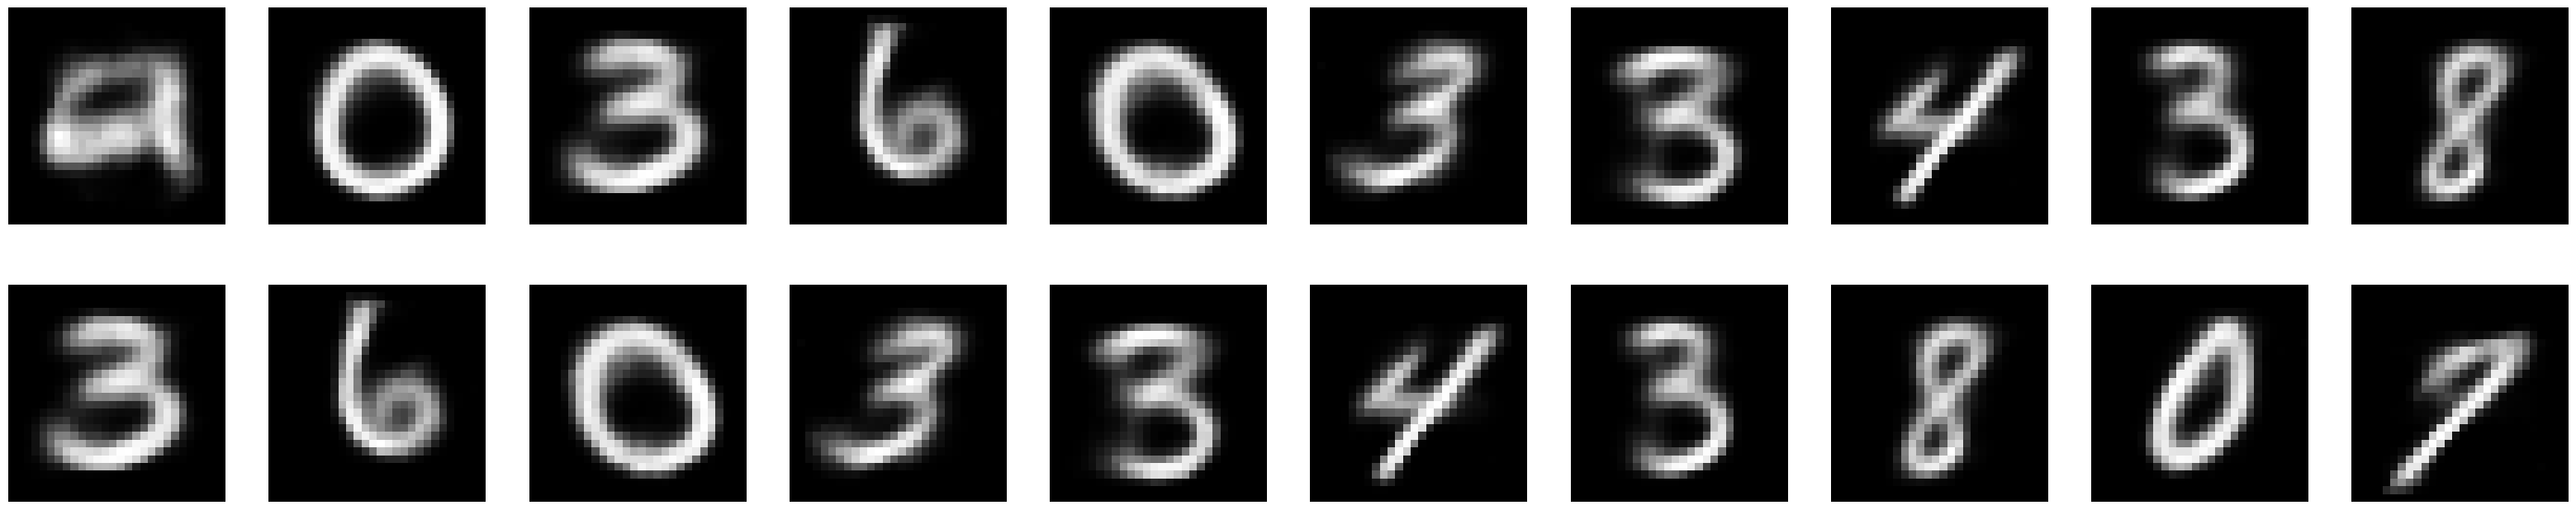

In [7]:
### plot images generated as gray scale ### 
gen = model.generate_data(binary=False)

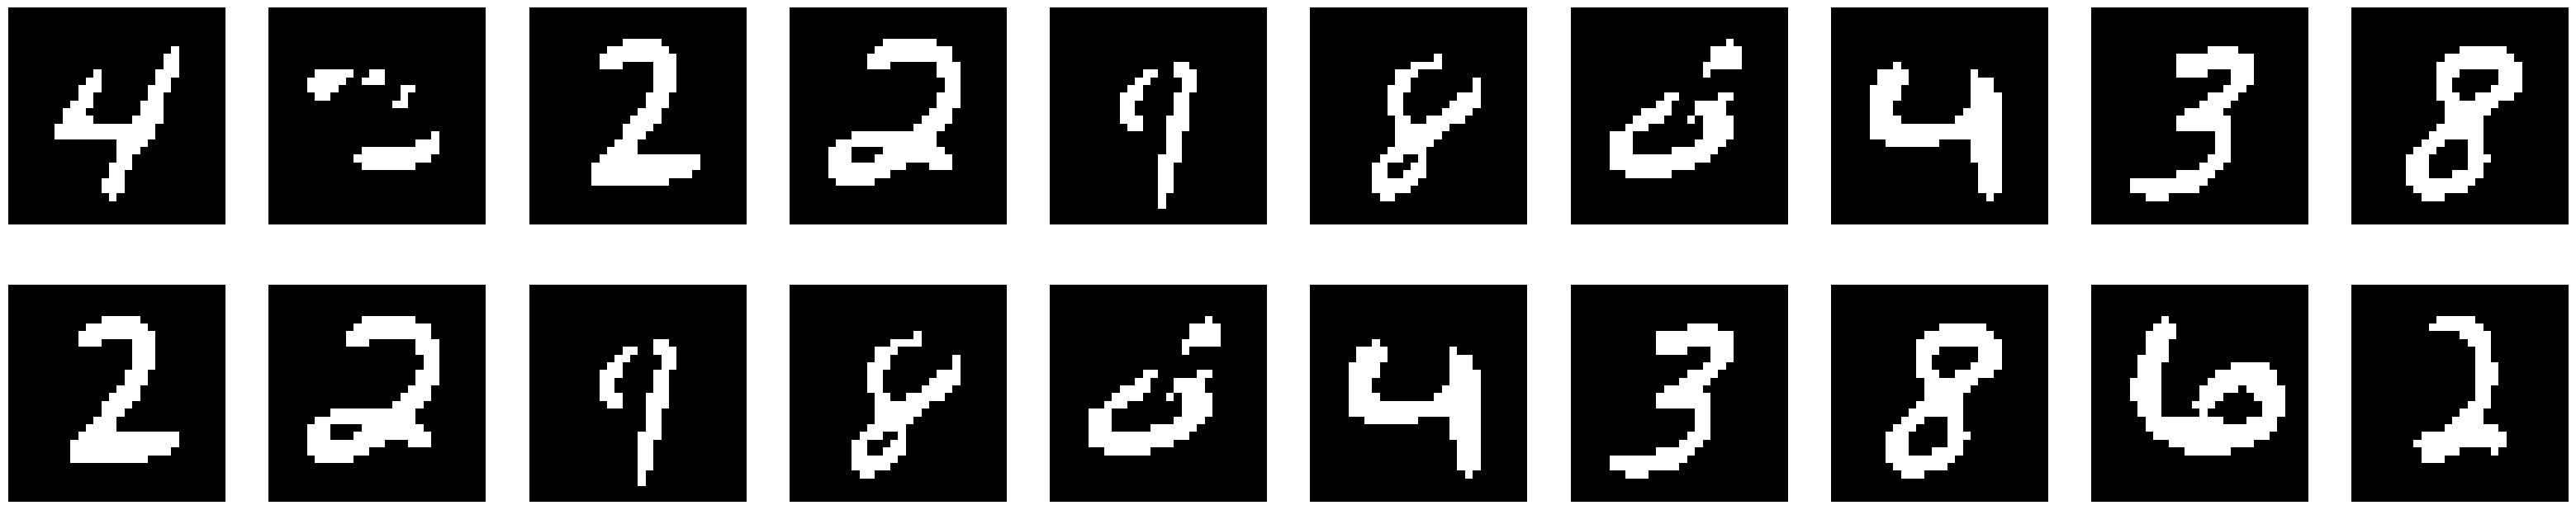

In [8]:
### plot images generated as binary images ### 
gen = model.generate_data()

### Sample latent space

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm

In [9]:
grid = [[x, y] for x in norm.ppf(np.linspace(0.05, 0.995, 5)) for y in norm.ppf(np.linspace(0.05, 0.995, 5))]
latent_space_traversal = model.generate_samples(samples_pz=torch.tensor(grid, dtype=torch.float32).to(model.device))['generations'].detach().cpu().numpy()
latent_space_traversal = latent_space_traversal.squeeze()

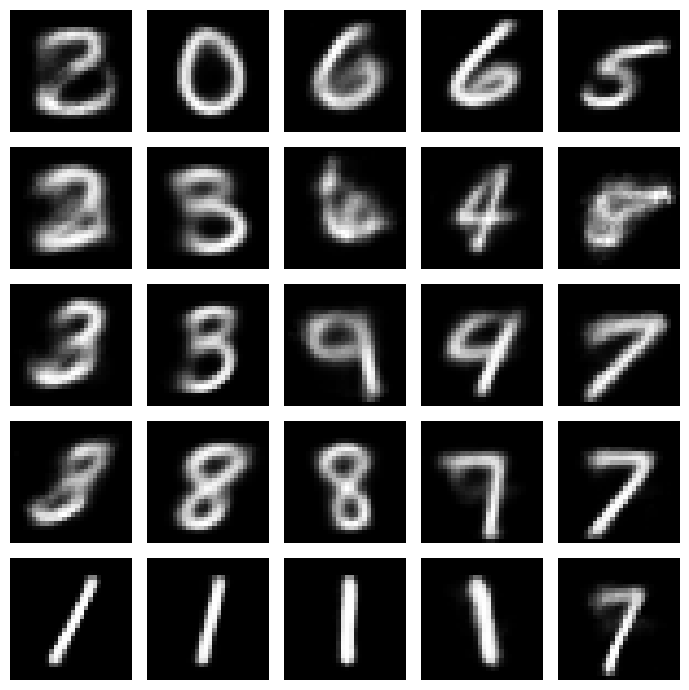

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        ax.imshow(latent_space_traversal[5*i+j].reshape(28, 28), cmap='gray')
        ax.axis('off')
plt.tight_layout();

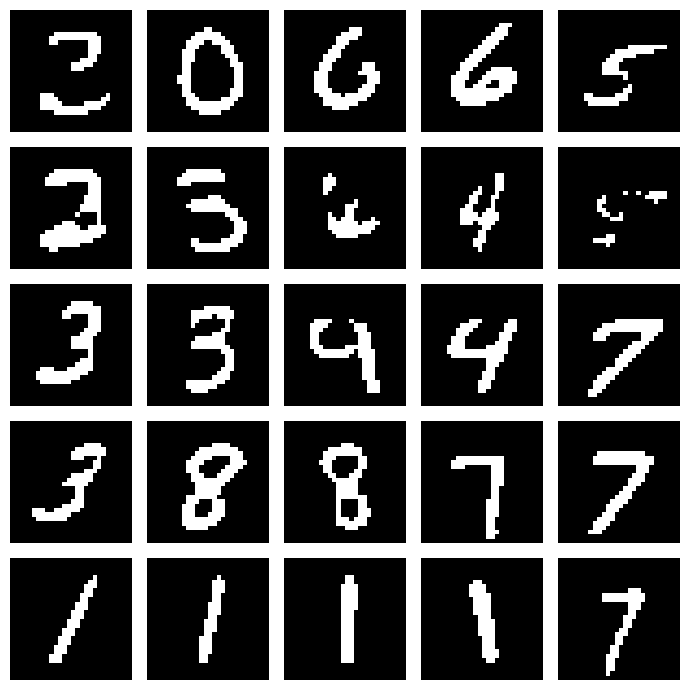

In [11]:
fig, axs = plt.subplots(5, 5, figsize=(7, 7))

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        z = np.where(latent_space_traversal[5*i+j].reshape(28, 28) >=0.5, 1, 0)
        ax.imshow(z, cmap='gray')
        ax.axis('off')
plt.tight_layout();

In [12]:
model.compute_fid_score(X_test[:5000])

927.6501081749627

## Tune hyperparameters to minimize FID

In [9]:
import pickle
from tqdm import tqdm
from IPython.display import clear_output

PATH = './vae_fid_scores.pkl'

def load_dict(path=PATH):
    with open(path, 'rb') as handle:
        d = pickle.load(handle)
    return d

def save_dict(d, path=PATH):
    with open(path, 'wb') as handle:
        pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
betas = [0.01, 0.1, 0.5, 1, 1.5, 2.5, 5, 10, 100]
latent_dims = [2, 3, 5, 10, 100, 200, 500]
alpha_lrelus = [0, 0.01, 0.1, 0.2, 0.3, 0.5]

VAE 220: beta=1.5, latent_dim=10, alpha=0.2:  58%|█████▊    | 220/378 [7:07:45<71:49:28, 1636.51s/VAE, alpha=0.2, beta=0.01, fid=895, fid_cur=932, l_dim=2]

##### PATIENCE TRIGGERED!
Epoch 339: error = 49.8398


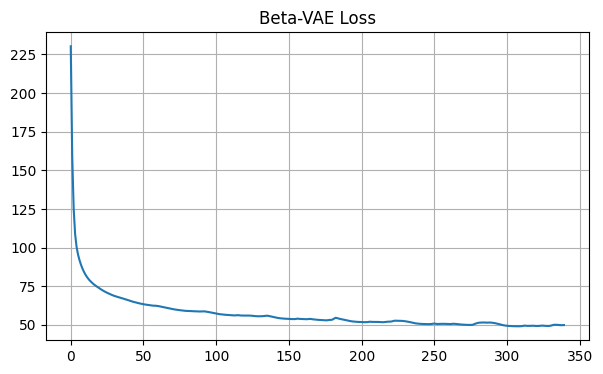

In [11]:
nb_to_test = len(betas) * len(latent_dims) * len(alpha_lrelus)

counter = 0
best_fid = np.inf
with tqdm(range(nb_to_test), unit='VAE') as bar:
    for alpha_lrelu in alpha_lrelus:
        for latent_dim in latent_dims:
            for beta in betas:
                bar.set_description(f'VAE {counter}: beta={beta}, latent_dim={latent_dim}, alpha={alpha_lrelu}')

                dict_results = load_dict(PATH)
                if dict_results.get(f'{beta},{latent_dim},{alpha_lrelu}') is not None:
                    fid_score = dict_results.get(f'{beta},{latent_dim},{alpha_lrelu}')
                else:
                    model = VAEModel(latent_dim=latent_dim, beta=beta, alpha_lrelu=alpha_lrelu)
                    _ = model.train_vae(X_train, 1000, learning_rate=3e-4, batch_size=256, print_error_every=-1, patience=30)
                    fid_score = model.compute_fid_score(X_test[:5000])
                    dict_results[f'{beta},{latent_dim},{alpha_lrelu}'] = fid_score
                    save_dict(dict_results, PATH)

                counter += 1
                if fid_score <= best_fid:
                    best_fid = fid_score
                    best_beta = beta
                    best_latent_dim = latent_dim
                    best_alpha_lrelu = alpha_lrelu

                bar.set_postfix(fid=best_fid, beta=best_beta, alpha=best_alpha_lrelu, l_dim=best_latent_dim, fid_cur=fid_score)
                bar.update(1)
                clear_output(wait=False)

In [ ]:
### Load and sort the dictionary of results ###

dict_results = load_dict()
sorted_values = sorted(dict_results.items(), key=lambda item: item[1])  # Sort by the second element (value)
dict_results = dict(sorted_values)

In [ ]:
for x in range(5):
    print(list(dict_results.keys())[x], dict_results[list(dict_results.keys())[x]])

{'0.01,2,0.2': 895.4238838437268,
 '0.01,2,0.3': 898.3102429908839,
 '100,3,0.1': 908.6131982480205,
 '10,500,0.1': 909.8823945117831,
 '0.01,5,0.3': 911.357306628176,
 '0.1,2,0.3': 911.8670387764288,
 '0.01,2,0.5': 911.9863438368135,
 '0.01,3,0.1': 912.0348434755915,
 '0.01,3,0.5': 913.0559944192823,
 '100,3,0.5': 913.4875377880597,
 '100,3,0.3': 914.1156461248908,
 '0.01,5,0.1': 914.3761690413656,
 '100,100,0.5': 914.6514079422107,
 '0.01,10,0.01': 915.214043071929,
 '100,200,0.5': 915.805075373485,
 '100,100,0.3': 915.8267756551949,
 '0.1,2,0.5': 915.8936980388505,
 '100,500,0.5': 916.1431659816006,
 '10,200,0.5': 916.9846819223379,
 '0.1,2,0.1': 917.0861580255746,
 '1.5,100,0.3': 917.1124331321934,
 '0.01,2,0.1': 917.2211567698417,
 '5,200,0.5': 917.5197648725757,
 '5,100,0.5': 917.574093865248,
 '0.01,500,0.5': 917.718000280949,
 '10,500,0.5': 917.7638991961508,
 '1,200,0.1': 917.8477019516087,
 '0.1,500,0.5': 917.9715357239179,
 '10,100,0.3': 918.0868817524379,
 '100,200,0.3': 91

In [ ]:
plt.scatter(range(len(dict_results)), dict_results.keys());